In [ ]:


# puis monter
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 70
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/controls_left"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/controls_left/saved_models_controls_left"
sample_dir = "/content/drive/MyDrive/controls_left/generated_samples_controls_left"
data_path = "/content/drive/MyDrive/controls_left/controls_all_left.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "controls" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets contrôles")

# === Chargement des données controls left ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour controls pied gauche")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


✓ Poids préentraînés chargés depuis les sujets contrôles


Epoch 1/70: 100%|██████████| 17/17 [04:13<00:00, 14.93s/it]



Epoch 1 | Critic: -1.0341 | Generator: -7.8539


Epoch 2/70: 100%|██████████| 17/17 [04:08<00:00, 14.64s/it]



Epoch 2 | Critic: -1.1378 | Generator: -6.2782


Epoch 3/70: 100%|██████████| 17/17 [04:09<00:00, 14.65s/it]



Epoch 3 | Critic: -0.9278 | Generator: -6.7113


Epoch 4/70: 100%|██████████| 17/17 [04:10<00:00, 14.75s/it]



Epoch 4 | Critic: -1.0143 | Generator: 0.7613


Epoch 5/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 5 | Critic: -0.9283 | Generator: 20.5807


Epoch 6/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 6 | Critic: -1.1364 | Generator: 0.9585


Epoch 7/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 7 | Critic: -1.3529 | Generator: 16.8014


Epoch 8/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 8 | Critic: -1.2357 | Generator: 20.4234


Epoch 9/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 9 | Critic: -1.1752 | Generator: 11.1631


Epoch 10/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 10 | Critic: -1.0708 | Generator: -13.0660


Epoch 11/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 11 | Critic: -0.7440 | Generator: 25.1856


Epoch 12/70: 100%|██████████| 17/17 [04:06<00:00, 14.51s/it]



Epoch 12 | Critic: -1.0811 | Generator: 37.5813


Epoch 13/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 13 | Critic: -0.7749 | Generator: 23.2020


Epoch 14/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 14 | Critic: -0.8394 | Generator: -4.1245


Epoch 15/70: 100%|██████████| 17/17 [04:07<00:00, 14.57s/it]



Epoch 15 | Critic: -0.9669 | Generator: -10.0331


Epoch 16/70: 100%|██████████| 17/17 [04:07<00:00, 14.56s/it]



Epoch 16 | Critic: -0.6932 | Generator: -1.1054


Epoch 17/70: 100%|██████████| 17/17 [04:07<00:00, 14.56s/it]



Epoch 17 | Critic: -0.9559 | Generator: -21.9384


Epoch 18/70: 100%|██████████| 17/17 [04:05<00:00, 14.46s/it]



Epoch 18 | Critic: -0.6239 | Generator: -30.4235


Epoch 19/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 19 | Critic: -0.5278 | Generator: 12.4163


Epoch 20/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 20 | Critic: -0.6562 | Generator: 2.4075


Epoch 21/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 21 | Critic: -0.8153 | Generator: 3.5145


Epoch 22/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 22 | Critic: -0.5878 | Generator: 32.5258


Epoch 23/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 23 | Critic: -1.0124 | Generator: -28.4439


Epoch 24/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 24 | Critic: -0.6441 | Generator: 14.9799


Epoch 25/70: 100%|██████████| 17/17 [04:08<00:00, 14.60s/it]



Epoch 25 | Critic: -0.4267 | Generator: -17.9612


Epoch 26/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 26 | Critic: -0.4276 | Generator: 6.9361


Epoch 27/70: 100%|██████████| 17/17 [04:40<00:00, 16.49s/it]



Epoch 27 | Critic: -0.1790 | Generator: 3.7648


Epoch 28/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 28 | Critic: -0.2421 | Generator: -7.7219


Epoch 29/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 29 | Critic: -0.1948 | Generator: -0.5459


Epoch 30/70: 100%|██████████| 17/17 [04:07<00:00, 14.53s/it]



Epoch 30 | Critic: -0.0343 | Generator: 2.4867


Epoch 31/70: 100%|██████████| 17/17 [04:07<00:00, 14.56s/it]



Epoch 31 | Critic: -0.5145 | Generator: 6.7481


Epoch 32/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 32 | Critic: -0.8195 | Generator: 11.3738


Epoch 33/70: 100%|██████████| 17/17 [04:08<00:00, 14.61s/it]



Epoch 33 | Critic: -0.7285 | Generator: 27.9741


Epoch 34/70: 100%|██████████| 17/17 [04:06<00:00, 14.48s/it]



Epoch 34 | Critic: -0.6178 | Generator: 27.2245


Epoch 35/70: 100%|██████████| 17/17 [04:07<00:00, 14.53s/it]



Epoch 35 | Critic: -0.4752 | Generator: 25.0813


Epoch 36/70: 100%|██████████| 17/17 [04:06<00:00, 14.52s/it]



Epoch 36 | Critic: -1.1084 | Generator: 27.9209


Epoch 37/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 37 | Critic: -0.8222 | Generator: -1.1544


Epoch 38/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 38 | Critic: -0.5027 | Generator: 17.0694


Epoch 39/70: 100%|██████████| 17/17 [04:05<00:00, 14.46s/it]



Epoch 39 | Critic: -0.8574 | Generator: 23.1798


Epoch 40/70: 100%|██████████| 17/17 [04:06<00:00, 14.51s/it]



Epoch 40 | Critic: -0.5527 | Generator: 8.7096


Epoch 41/70: 100%|██████████| 17/17 [04:03<00:00, 14.35s/it]



Epoch 41 | Critic: -0.4972 | Generator: 7.7941


Epoch 42/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 42 | Critic: -0.7888 | Generator: 15.8316


Epoch 43/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 43 | Critic: -0.7277 | Generator: 9.3001


Epoch 44/70: 100%|██████████| 17/17 [04:06<00:00, 14.52s/it]



Epoch 44 | Critic: -0.7256 | Generator: 7.8601


Epoch 45/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 45 | Critic: -1.1534 | Generator: 4.8890


Epoch 46/70: 100%|██████████| 17/17 [04:07<00:00, 14.58s/it]



Epoch 46 | Critic: -1.2194 | Generator: 1.3696


Epoch 47/70: 100%|██████████| 17/17 [04:07<00:00, 14.58s/it]



Epoch 47 | Critic: -1.0479 | Generator: -2.2349


Epoch 48/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 48 | Critic: -0.7764 | Generator: 11.2744


Epoch 49/70: 100%|██████████| 17/17 [04:07<00:00, 14.55s/it]



Epoch 49 | Critic: -0.9352 | Generator: 13.5853


Epoch 50/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 50 | Critic: -0.9369 | Generator: -10.9905


Epoch 51/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 51 | Critic: -0.6989 | Generator: 12.1329


Epoch 52/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 52 | Critic: -1.1002 | Generator: 14.3512


Epoch 53/70: 100%|██████████| 17/17 [04:07<00:00, 14.56s/it]



Epoch 53 | Critic: -0.9506 | Generator: 23.6904


Epoch 54/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 54 | Critic: -0.9582 | Generator: 12.8908


Epoch 55/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 55 | Critic: -0.9179 | Generator: 14.1902


Epoch 56/70: 100%|██████████| 17/17 [04:04<00:00, 14.41s/it]



Epoch 56 | Critic: -0.9128 | Generator: 14.2309


Epoch 57/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 57 | Critic: -0.9717 | Generator: -3.2848


Epoch 58/70: 100%|██████████| 17/17 [04:03<00:00, 14.34s/it]



Epoch 58 | Critic: -0.7805 | Generator: -11.9643


Epoch 59/70: 100%|██████████| 17/17 [04:03<00:00, 14.32s/it]



Epoch 59 | Critic: -1.2329 | Generator: -10.0929


Epoch 60/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 60 | Critic: -0.8964 | Generator: -0.1264


Epoch 61/70: 100%|██████████| 17/17 [04:03<00:00, 14.33s/it]



Epoch 61 | Critic: -0.8922 | Generator: 25.5313


Epoch 62/70: 100%|██████████| 17/17 [04:07<00:00, 14.57s/it]



Epoch 62 | Critic: -0.9783 | Generator: 22.7551


Epoch 63/70: 100%|██████████| 17/17 [04:05<00:00, 14.47s/it]



Epoch 63 | Critic: -0.9025 | Generator: 24.7149


Epoch 64/70: 100%|██████████| 17/17 [04:05<00:00, 14.43s/it]



Epoch 64 | Critic: -0.7881 | Generator: 17.2289


Epoch 65/70: 100%|██████████| 17/17 [04:04<00:00, 14.39s/it]



Epoch 65 | Critic: -0.9930 | Generator: 18.4931


Epoch 66/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 66 | Critic: -0.9101 | Generator: 16.9632


Epoch 67/70: 100%|██████████| 17/17 [04:05<00:00, 14.44s/it]



Epoch 67 | Critic: -1.1862 | Generator: -1.9501


Epoch 68/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 68 | Critic: -0.9003 | Generator: 6.2449


Epoch 69/70: 100%|██████████| 17/17 [04:05<00:00, 14.42s/it]



Epoch 69 | Critic: -0.9686 | Generator: -16.1444


Epoch 70/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 70 | Critic: -1.0957 | Generator: -10.1931
✓ Fine-tuning terminé pour controls pied gauche


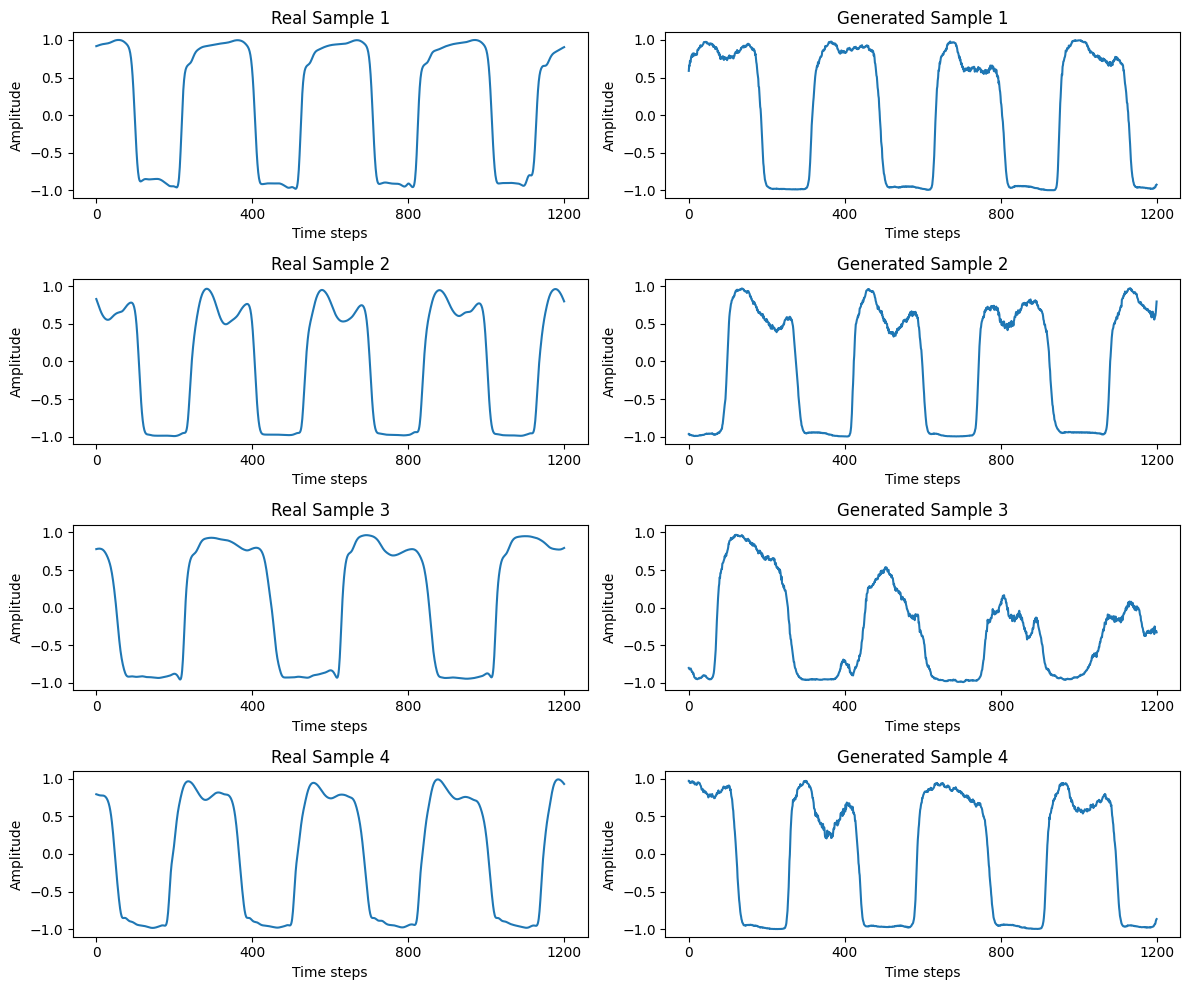

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/controls_left/controls_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/controls_left/saved_models_controls_left/generator_epoch_70.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.02007054946629649
🔄 Average DTW Distance: 9.899901876757179
🔁 Average Cross-Correlation: 0.08672219115351743


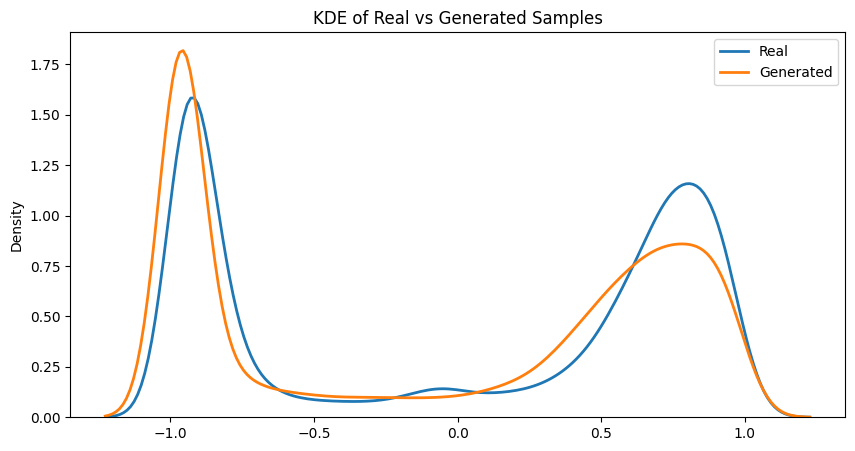

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/controls_left/controls_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/controls_left/saved_models_controls_left/generator_epoch_70.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()
